In [1]:
import collections
import datetime
import itertools
import json
import time

#import ijson
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import numpy as np
import pandas as pd
import tqdm

In [52]:
LANGUAGES = {
    "python": "Python",
    "r": "R",
    "javascript": "Javascript",
    "java": "Java",
    "cpp": "C++",
    "php": "PHP",
    "ruby": "Ruby",
    "perl": "Perl",
    "rust": "Rust",
    "swift": "Swift",
    "objectivec": "Objective C",
    "c#": "C#",
}

## Heaps's Law

Processing python
	 Opening resources...
Fitted k: 1.761653537305075e-10
Fitted alpha: 1.6755736926063534
R² value: 0.9959582578120684
Processing r
	 Opening resources...
Fitted k: 7.304505391916182e-11
Fitted alpha: 1.637711894724874
R² value: 0.9959582578120684
Processing javascript
	 Opening resources...
Fitted k: 8.569604051119784e-14
Fitted alpha: 2.015244068670759
R² value: 0.9959582578120684
Processing java
	 Opening resources...
Fitted k: 1.7566061425579845e-07
Fitted alpha: 1.2255300690088895
R² value: 0.9959582578120684
Processing cpp
	 Opening resources...
Fitted k: 6.829210791493114e-08
Fitted alpha: 1.3659843341742703
R² value: 0.9959582578120684
Processing php
	 Opening resources...
Fitted k: 2.2530597613683806e-05
Fitted alpha: 1.04993092945789
R² value: 0.9959582578120684
Processing ruby
	 Opening resources...
Fitted k: 0.00023589395195785126
Fitted alpha: 0.8497107349171863
R² value: 0.9959582578120684
Processing perl
	 Opening resources...
Fitted k: 0.0008970140808392

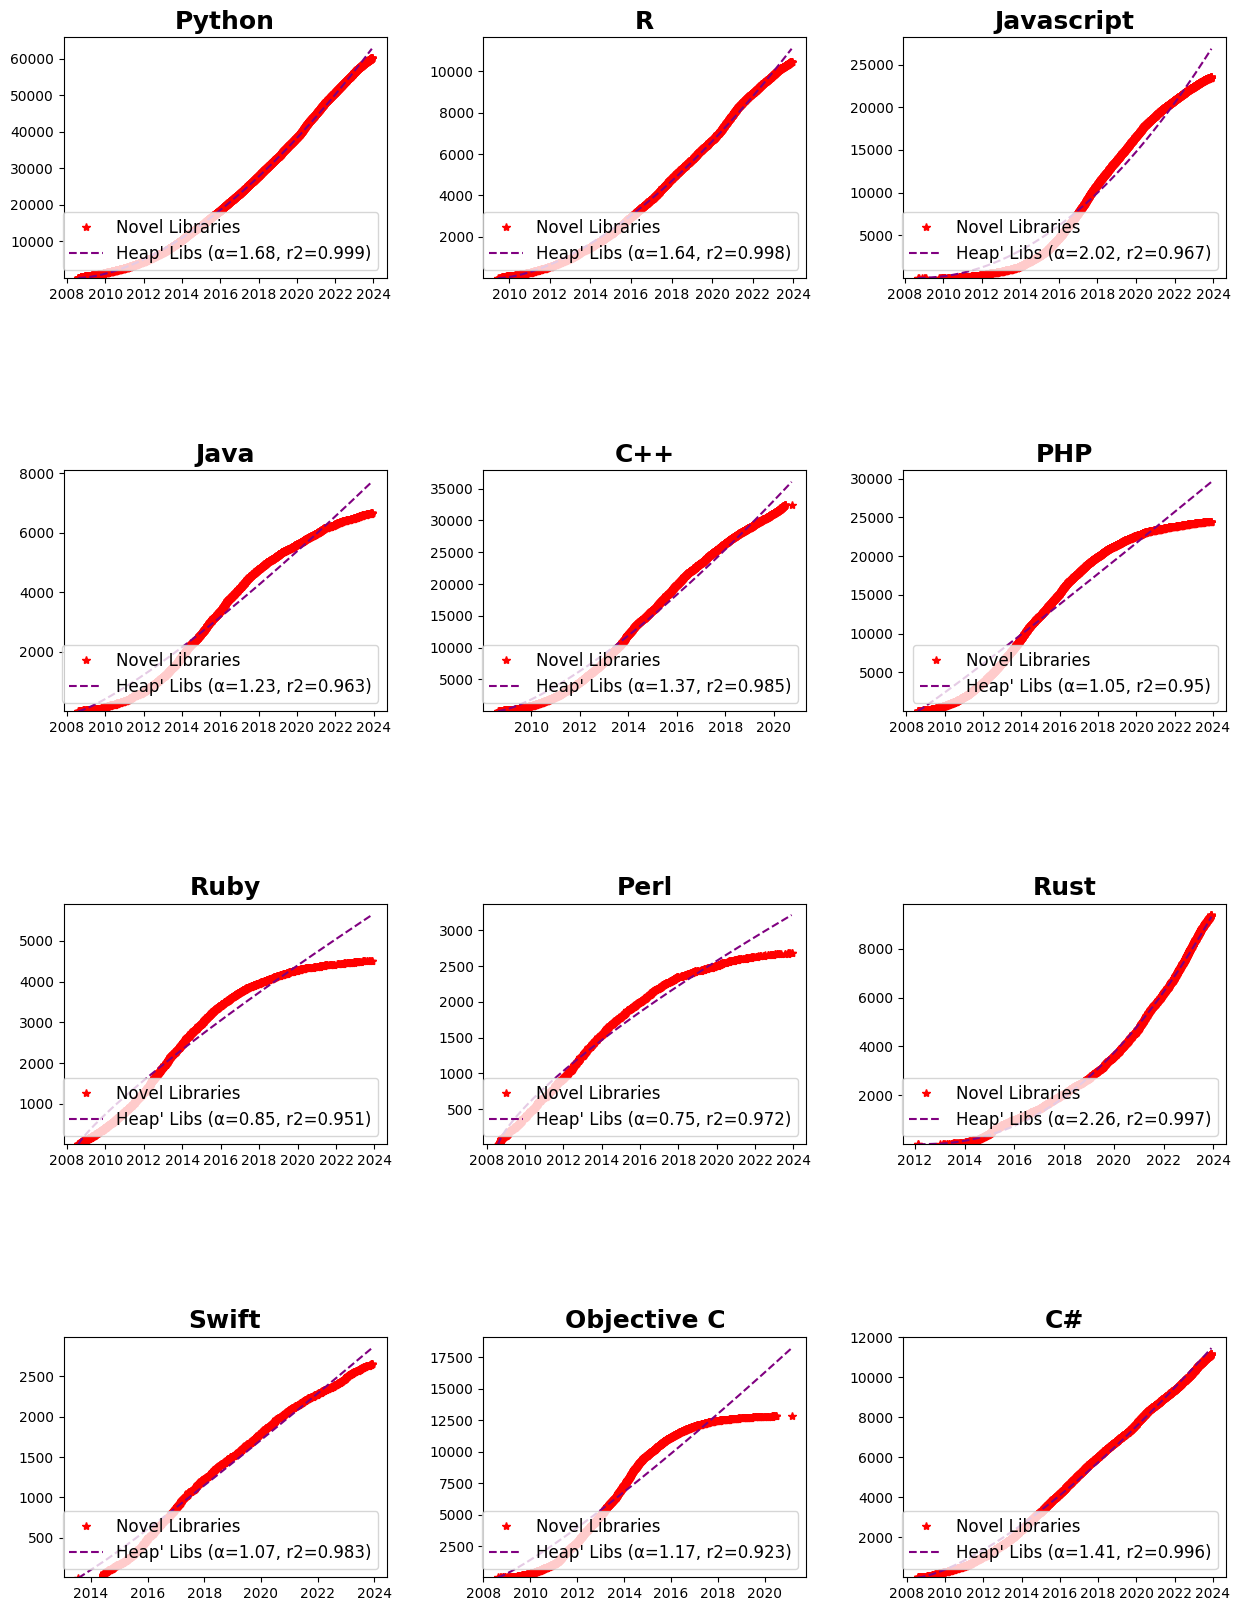

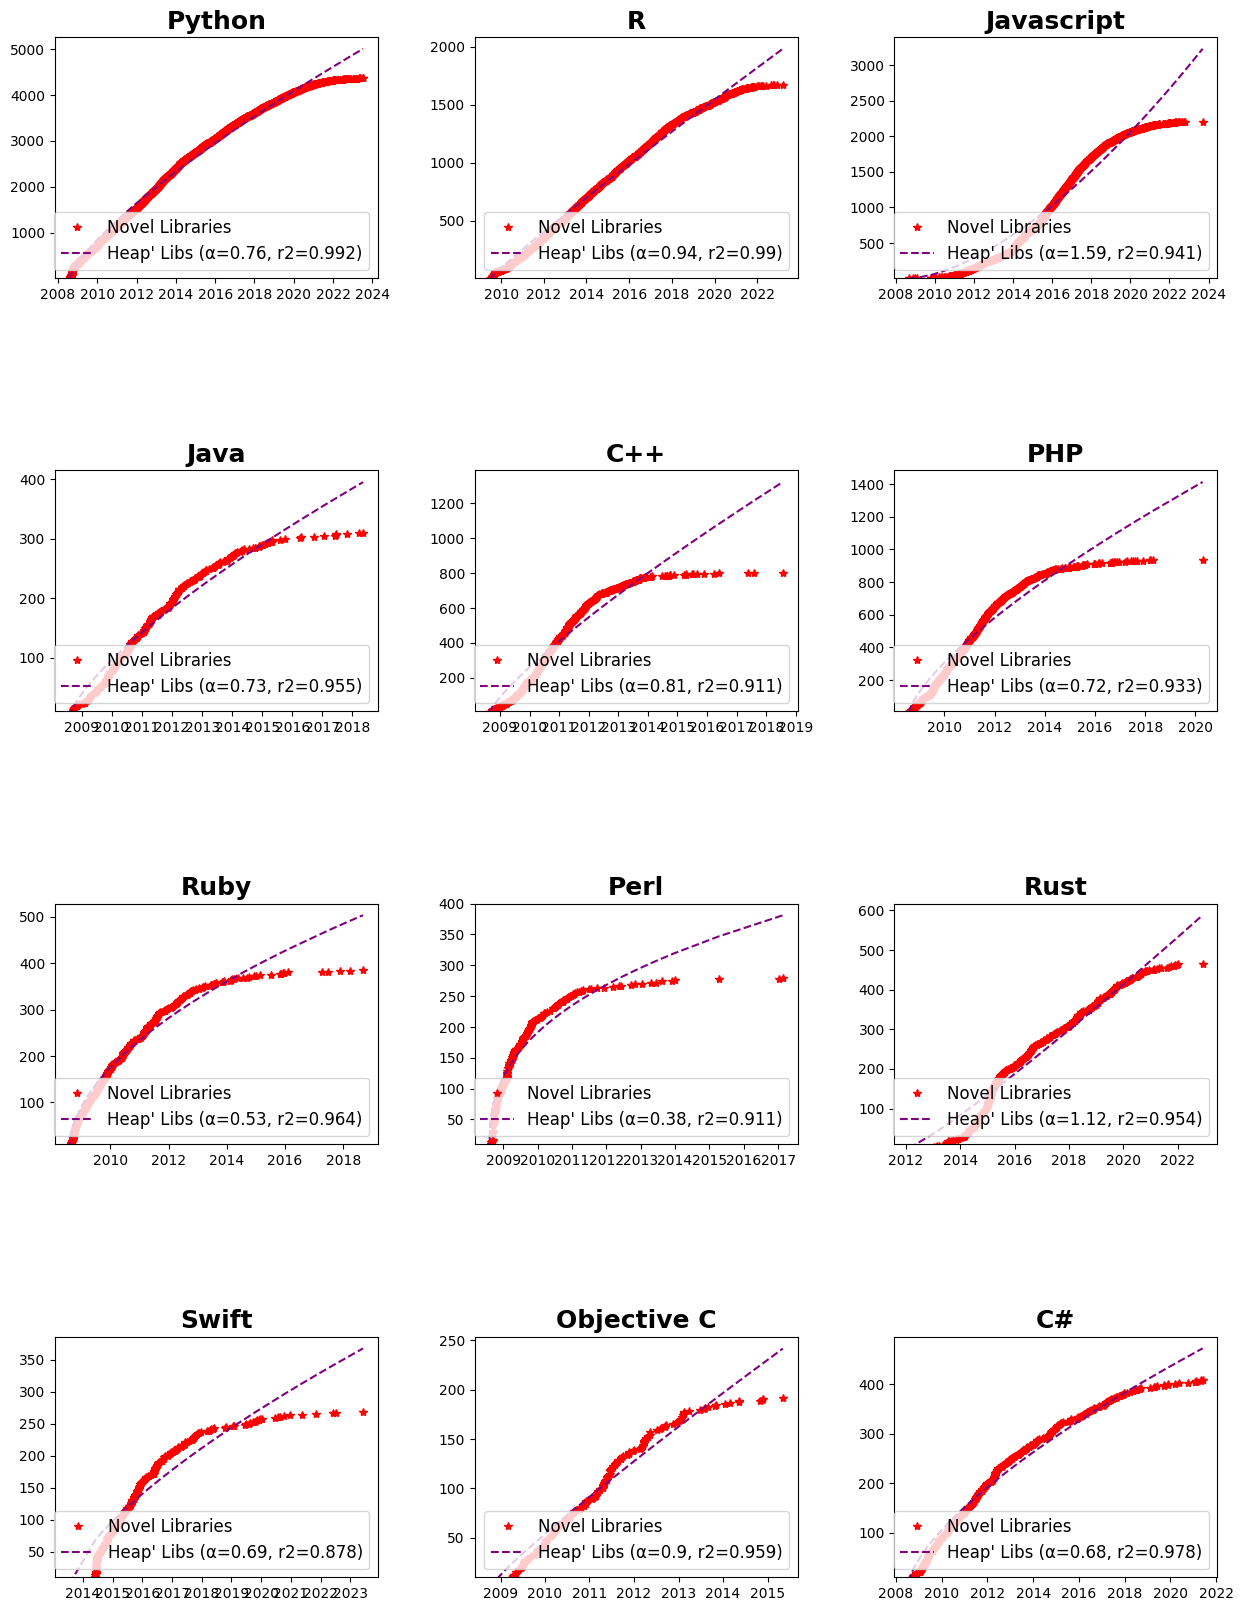

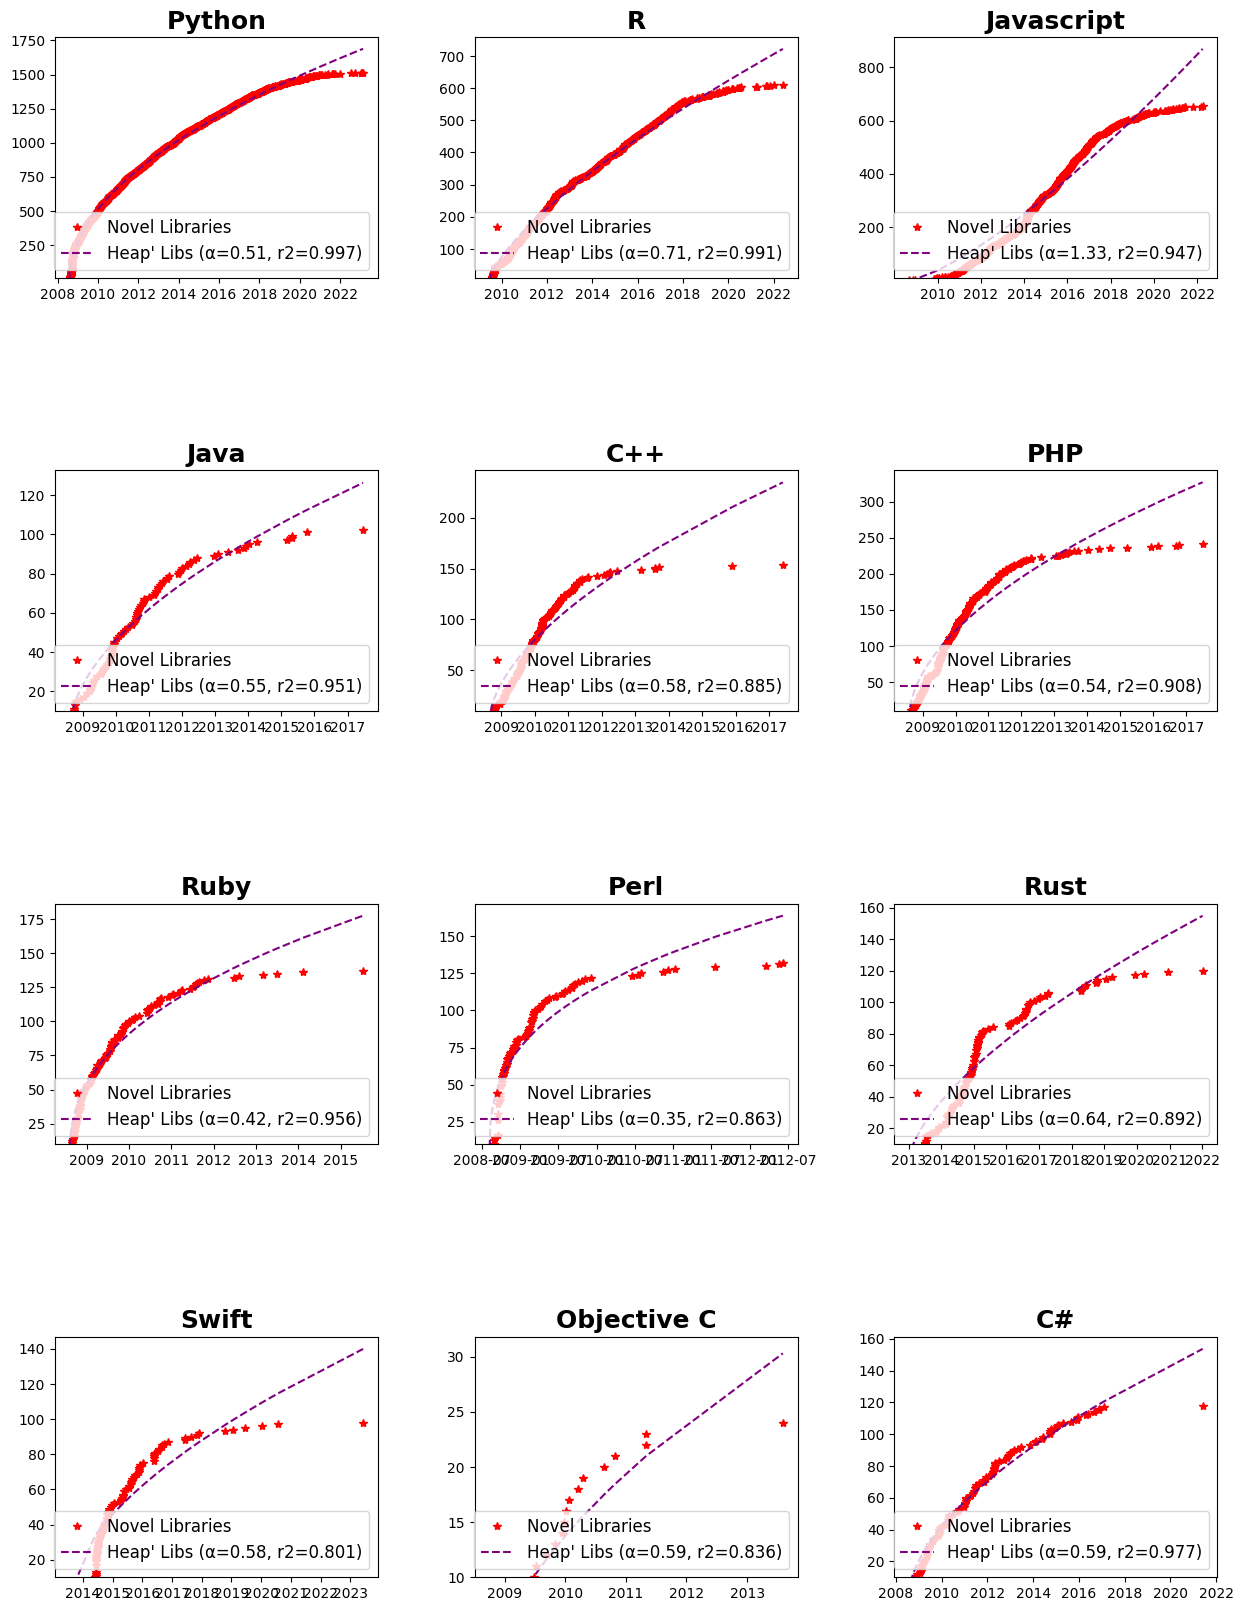

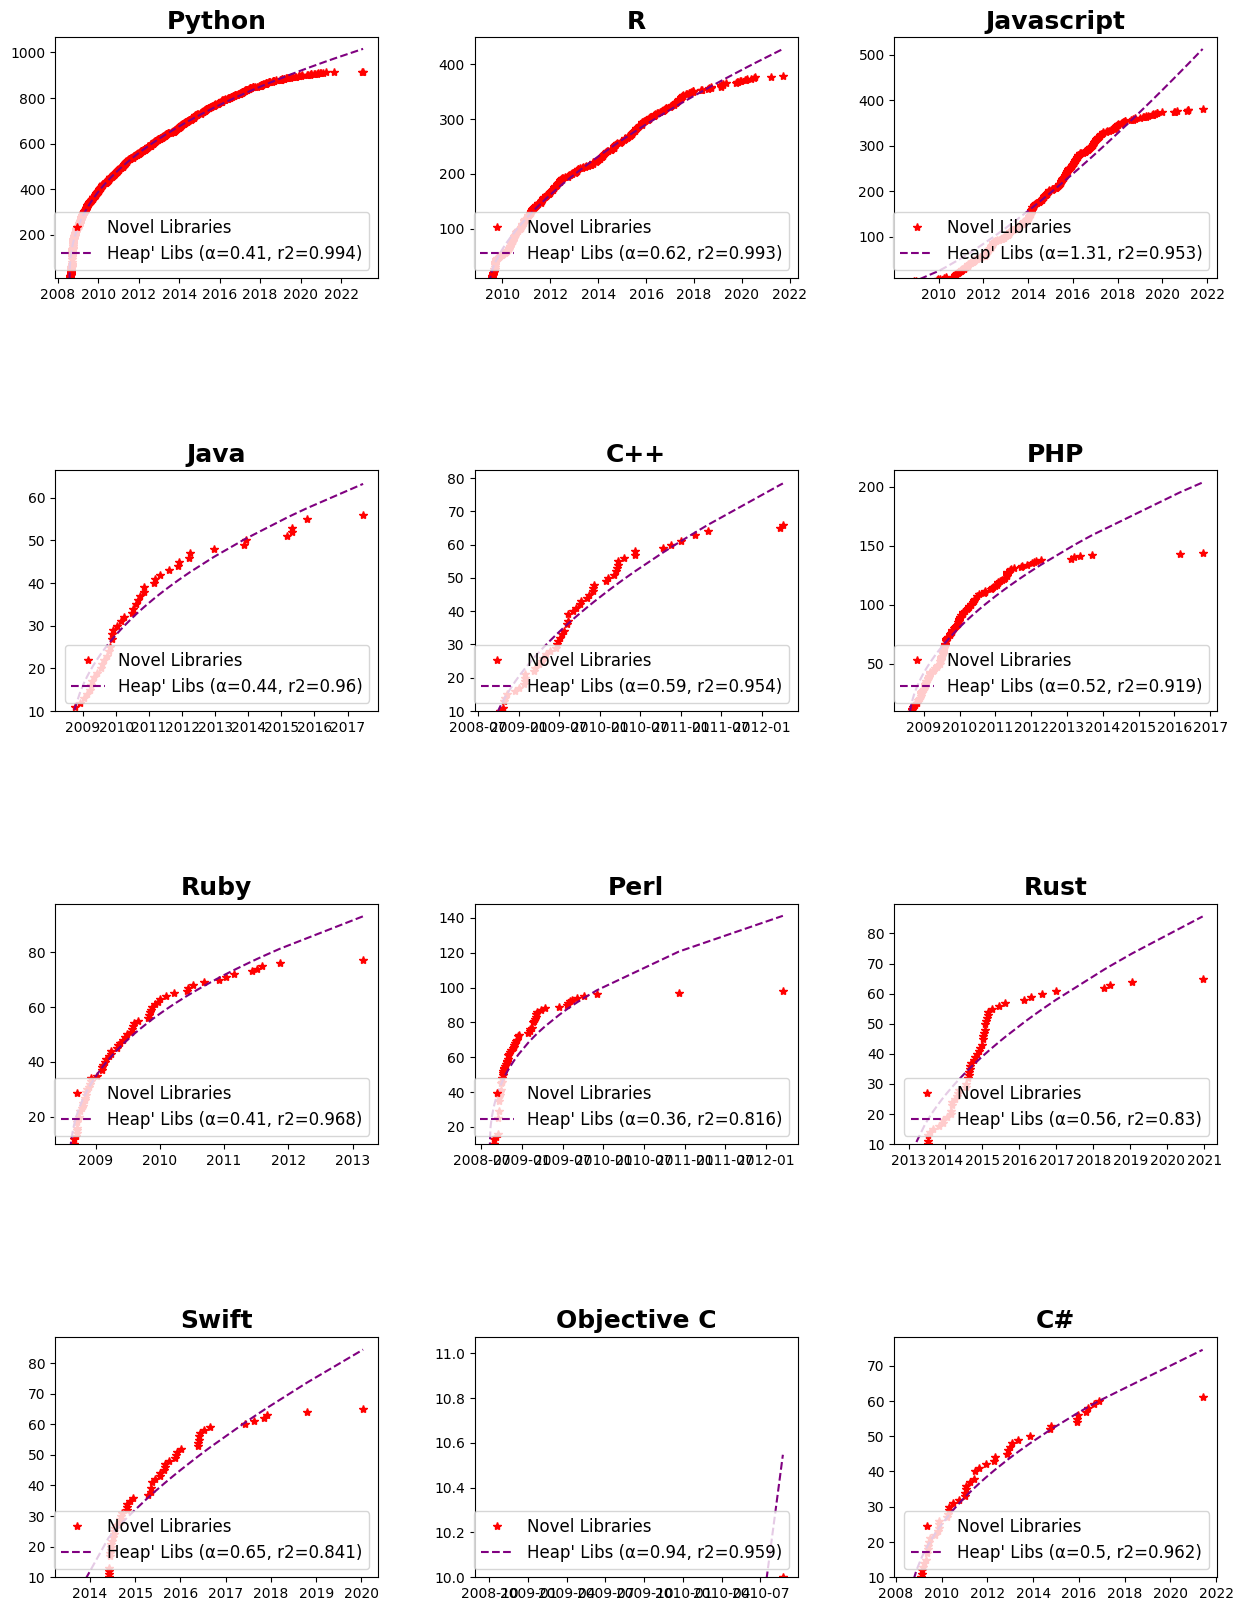

In [65]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import ScalarFormatter, LogFormatterExponent,LogFormatterMathtext
from scipy.optimize import curve_fit


import time
from sklearn.linear_model import LinearRegression


%matplotlib inline

for LIMIT in [0, 10, 50, 100]:

    lib_alphas = {}
    lib_r2 = {}
    
    square_size = 5
    rows, columns = (len(LANGUAGES) + 2) // 3, 3
    fig = plt.figure(figsize=(square_size * columns, square_size * rows))
    gs = GridSpec(rows, columns, figure=fig)
    plt.subplots_adjust(hspace=0.8, wspace=0.3)
    
    for index, language in enumerate(LANGUAGES):
        print(f"Processing {language}")
        path_to_lib = f"data/results/{language}"
    
        i, j = index // columns, index % columns
        ax = fig.add_subplot(gs[i, j])
        
        print("\t Opening resources...")
        with open(f"{path_to_lib}/{language}_libs_first_dates.json") as handle:
            libs_to_dates = json.load(handle)
        with open(f"{path_to_lib}/{language}_pairs_first_dates.json") as handle:
            pairs_to_dates = json.load(handle)
        with open(f"{path_to_lib}/{language}_libs_count.json") as handle:
            libs_counts = json.load(handle)
    
        libs_to_dates = {k: v for k, v in libs_to_dates.items() if libs_counts.get(k, 0) > LIMIT}
        pairs_to_dates = {k: v for k, v in pairs_to_dates.items() if all(libs_counts.get(lib_, 0) > LIMIT for lib_ in k.split("|"))}
    
        libs_dates = [item["date"] for item in libs_to_dates.values()]
        sorted_libs_dates = sorted(libs_dates)
        libs_counts = collections.Counter(libs_dates)
        
        libs_xs = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in sorted(libs_counts.keys())]
    
        # monthly_binned_libs_counts = collections.defaultdict(int)
        # for item in sorted_libs_dates:
        #     monthly_binned_libs_counts["-".join(item.split("-")[:2])] += 1
        
        # ax.bar(
        #     sorted(monthly_binned_libs_counts.keys()),
        #     [monthly_binned_libs_counts[item] for item in sorted(monthly_binned_libs_counts.keys())])
        # ax.set_title(f'{LANGUAGES[language]}', fontsize=18, fontweight='bold')
        # ax.set_xticklabels(sorted(monthly_binned_libs_counts.keys()), rotation=90, fontsize=4)
        # continue
        
        libs_ys = list(itertools.accumulate([libs_counts[date] for date in sorted(libs_counts.keys())]))
        
        pairs_dates = [item["date"] for item in pairs_to_dates.values()]
        sorted_pairs_dates = sorted(pairs_dates)
        pairs_counts = collections.Counter(pairs_dates)
        
        pairs_xs = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in sorted_pairs_dates]
        pairs_ys = list(itertools.accumulate([pairs_counts[date] for date in sorted_pairs_dates]))
    
    
        ###########################
    
    
        # xs = [item.timestamp() - libs_xs[0].timestamp() + 1 for item in libs_xs]
        # xs_transformed = np.log(xs).reshape(-1 ,1 )
        # counts_transformed = np.log(np.array(xs) + 1)
        
        # model = LinearRegression()
        # model.fit(xs_transformed, counts_transformed)
        
        # alpha_libs = model.coef_[0]
        # log_c_libs = model.intercept_
        # c_libs = np.exp(log_c_libs)
        # r2_libs = model.score(xs_transformed, counts_transformed)
        # print(f"\tLibs Fit performed; alpha={alpha_libs} c={c_libs} r2_libs={r2_libs}")
        
        # lib_alphas[language] = alpha_libs
        # lib_r2[language] = r2_libs
    
    
        xs = np.array([dt.timestamp() - libs_xs[0].timestamp() + 1 for dt in libs_xs])
        
        # Define Heaps' Law function: V(N) = k * N^beta
        def heaps_law(N, k, beta):
            return k * N ** beta
        
        # Fit Heaps' Law to the data (xs, libs_ys)
        popt, pcov = curve_fit(heaps_law, xs, libs_ys, maxfev=10000, p0=[1.0, 0.5])
        
        # Extract the fitted parameters
        k, beta = popt
        
        # Compute the predicted values using the fitted Heaps' Law model
        predicted_ys = heaps_law(xs, *popt)
        
        # Compute the R² value to evaluate the fit
        ss_res = np.sum((libs_ys - predicted_ys) ** 2)  # Residual sum of squares
        ss_tot = np.sum((libs_ys - np.mean(libs_ys)) ** 2)  # Total sum of squares
        r_2 = 1 - (ss_res / ss_tot)
        
        # Print fitted parameters and R² value
        print(f"Fitted k: {k}")
        print(f"Fitted alpha: {beta}")
        print(f"R² value: {r_squared}")
        ###
        
        #ax.semilogy(libs_xs, libs_ys, label="Novel Libraries")
        #ax.semilogy(pairs_xs, pairs_ys, label="Novel Pair")
        #ax.plot(libs_xs, libs_ys, "*",label="Novel Libraries")
        ax.plot(libs_xs, libs_ys, "r*",label="Novel Libraries")
    
        #ax.plot(pairs_xs, pairs_ys,"^", label="Novel Pair")
        ax.plot(libs_xs, predicted_ys, "--", color="purple", label=f"Heap' Libs (α={round(beta, 2)}, r2={round(r_2, 3)})")
    
        
        ax.legend(fontsize=12, loc="lower right")
        ax.set_title(f'{LANGUAGES[language]}', fontsize=18, fontweight='bold')
        #ax.set_xscale('log')
        #ax.xaxis.set_major_formatter(LogFormatterMathtext(base=10))
         #ax.set_yscale('log')
        #ax.yaxis.set_major_formatter(LogFormatterMathtext(base=10))
        ax.set_ylim(bottom=10)
  
    plt.savefig(f"heaps_12_time_with_limit_{LIMIT}.png")

Processing python
	 Opening resources...
Processing r
	 Opening resources...
Processing javascript
	 Opening resources...
Processing java
	 Opening resources...
Processing cpp
	 Opening resources...
Processing php
	 Opening resources...
Processing ruby
	 Opening resources...
Processing perl
	 Opening resources...
Processing rust
	 Opening resources...
Processing swift
	 Opening resources...
Processing objectivec
	 Opening resources...
Processing c#
	 Opening resources...


(100, 336478.2637496649)

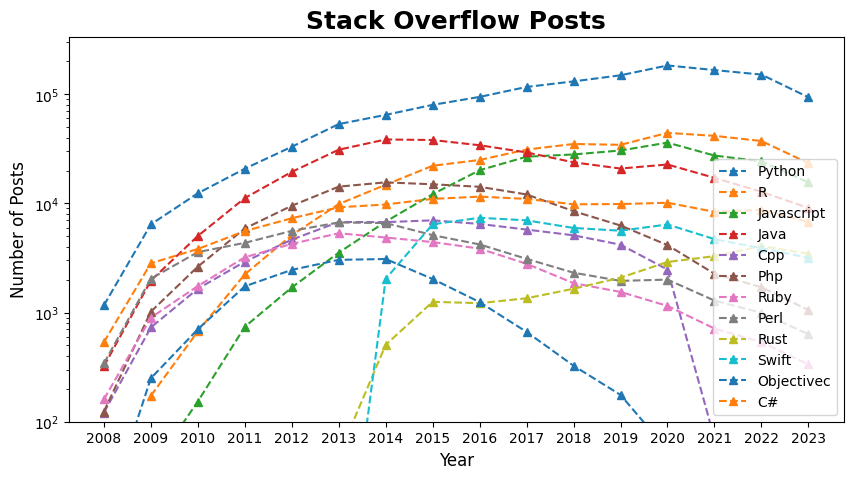

In [77]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import ScalarFormatter, LogFormatterExponent,LogFormatterMathtext
from scipy.optimize import curve_fit


import time
from sklearn.linear_model import LinearRegression


%matplotlib inline

LIMIT = 10
plt.figure(figsize=(10,5))
for index, language in enumerate(LANGUAGES):
    print(f"Processing {language}")
    path_to_lib = f"data/results/{language}"
    
    print("\t Opening resources...")
    post_count = collections.defaultdict(int)
    with open(f"{path_to_lib}/{language}_time_based_new.jsonl") as handle:
        for line in handle:
            data = json.loads(line)
            post_count[data["post_date"][:4]] += 1
    
    plt.plot(sorted(post_count.keys()), [post_count[k] for k in sorted(post_count.keys())], "^--",label=language.capitalize())
    
plt.legend(fontsize=10, loc="lower right")
plt.title('Stack Overflow Posts', fontsize=18, fontweight='bold')
plt.semilogy()
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Posts", fontsize=12)
plt.ylim(bottom=100)
